In [2]:
import torch
import torch.nn as nn
import zipfile
import shutil
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import cv2
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# Loading data
Using torch and torchvision to load data

In [3]:
#Extract archive
zip = zipfile.ZipFile ("C:/Users/jedrz/Downloads/archive (1).zip", "r")
zip.extractall("C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2")
zip.close()

In [4]:
def remove_readonly(func, path, _):
    os.chmod(path, stat.S_IWRITE)
    func(path)

# Definir las carpetas de origen y destino
folders = {
    'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/Train': 
    'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/train',
    
    'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/test': 
    'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/val',
}

for old_folder_path, new_folder_path in folders.items():
    if not os.path.exists(old_folder_path):
        print(f"Error: La carpeta de origen '{old_folder_path}' no existe.")
        continue


    # Intentar renombrar la carpeta de origen
    try:
        os.rename(old_folder_path, new_folder_path)
        print(f"Carpeta renombrada de '{old_folder_path}' a '{new_folder_path}' exitosamente.")
    except Exception as e:
        print(f"Error al renombrar '{old_folder_path}' a '{new_folder_path}': {e}")




Carpeta renombrada de 'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/Train' a 'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/train' exitosamente.
Error al renombrar 'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/test' a 'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/val': [WinError 183] No se puede crear un archivo que ya existe: 'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/test' -> 'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset/val'


In [5]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(310),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/jedrz/OneDrive - Fundacion Universidad de las Americas Puebla/Séptimo semestre/Visión artificial/model_2/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

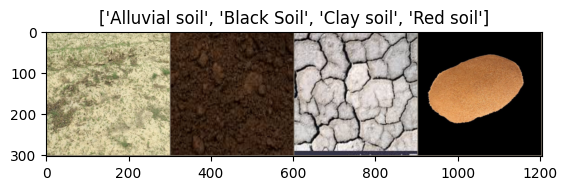

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


categories = ["Alluvial soil", "Black Soil", "Clay soil", "Red soil"]
sample_images = []

# Extraer una imagen de cada categoría
for category in categories:
    # Filtrar el dataset para la categoría deseada
    for inputs, labels in dataloaders['train']:
        if class_names[labels[0]] == category:
            sample_images.append(inputs[0])  # Tomar una imagen de la categoría
            break  # Detener el bucle después de encontrar una imagen

# Crear un grid con las imágenes de las cuatro categorías
out = torchvision.utils.make_grid(sample_images, nrow=4)

# Mostrar el grid con las etiquetas de las categorías
imshow(out, title=categories)

# Train the model

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7281 Acc: 0.7197
val Loss: 0.2756 Acc: 0.8971

Epoch 1/24
----------
train Loss: 0.5048 Acc: 0.8246
val Loss: 0.3350 Acc: 0.8588

Epoch 2/24
----------
train Loss: 0.5450 Acc: 0.8221
val Loss: 0.3007 Acc: 0.9000

Epoch 3/24
----------
train Loss: 0.4687 Acc: 0.8262
val Loss: 0.3437 Acc: 0.9088

Epoch 4/24
----------
train Loss: 0.4360 Acc: 0.8615
val Loss: 0.5301 Acc: 0.8029

Epoch 5/24
----------
train Loss: 0.3685 Acc: 0.8746
val Loss: 0.2251 Acc: 0.9324

Epoch 6/24
----------
train Loss: 0.3910 Acc: 0.8779
val Loss: 0.2302 Acc: 0.9353

Epoch 7/24
----------
train Loss: 0.2235 Acc: 0.9254
val Loss: 0.1637 Acc: 0.9353

Epoch 8/24
----------
train Loss: 0.2056 Acc: 0.9369
val Loss: 0.1506 Acc: 0.9441

Epoch 9/24
----------
train Loss: 0.1825 Acc: 0.9328
val Loss: 0.1654 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.1565 Acc: 0.9393
val Loss: 0.1666 Acc: 0.9471

Epoch 11/24
----------
train Loss: 0.1971 Acc: 0.9328
val Loss: 0.1837 Acc: 0.9382

Ep

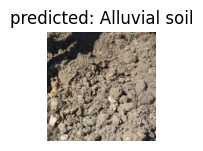

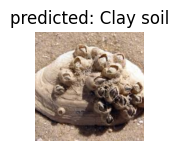

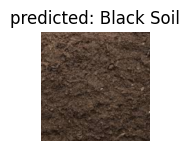

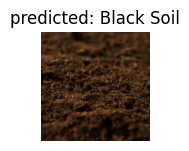

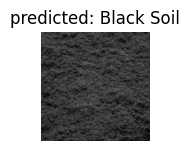

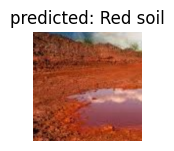

In [15]:
visualize_model(model_ft)

In [17]:
# Guardar el modelo entrenado completo en un archivo .pth
torch.save(model_ft, 'best_model.pth')
print("Modelo completo guardado en best_model.pth")

# Alternativamente, guardar solo los parámetros del modelo
torch.save(model_ft.state_dict(), 'best_model_params.pth')
print("Parámetros del modelo guardados en best_model_params.pth")
# Cargar el modelo completo
loaded_model = torch.load('best_model.pth')
loaded_model.to(device)  # Mover el modelo al dispositivo (CPU/GPU)
print("Modelo completo cargado desde best_model.pth")

Modelo completo guardado en best_model.pth
Parámetros del modelo guardados en best_model_params.pth
Modelo completo cargado desde best_model.pth


C:\Users\jedrz\AppData\Local\Temp\ipykernel_11136\666914621.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('best_model.pth')
